/home/hajjohn1/bachelors-thesis/py-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Detected 14 out of 53 events (26.4%).
Saved 53 event records to /home/hajjohn1/bachelors-thesis/Results/events/eval_event_detection_iforest_run_20250730_160858.json


/tmp/ipykernel_576376/1139504607.py:93: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('length_bin')['detected']


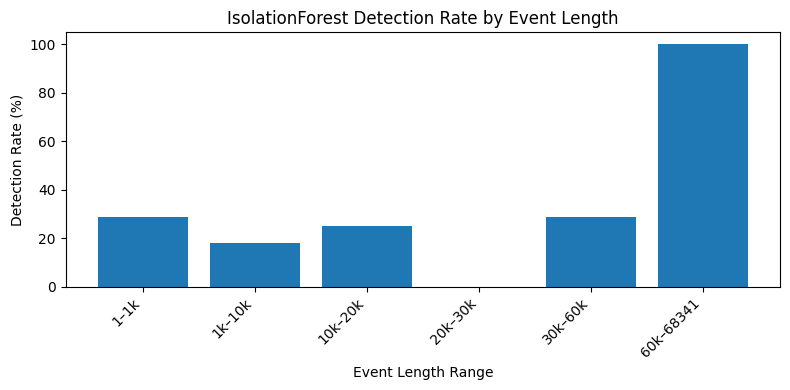

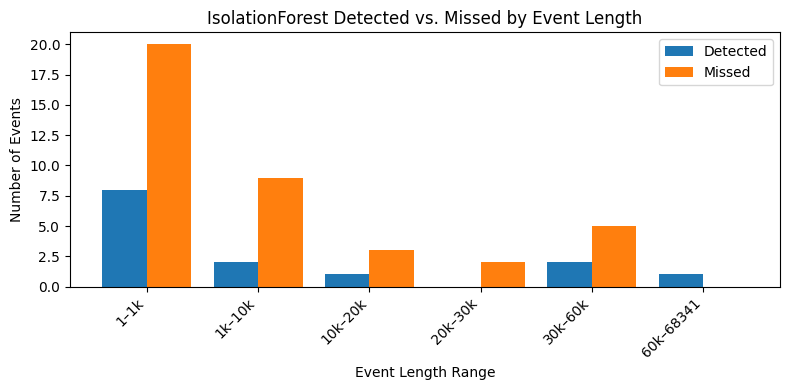

In [ ]:
import pandas as pd
import numpy as np
import json
from pathlib import Path
import joblib
import matplotlib.pyplot as plt

# Paths to load and save
BASE_DIR       = Path("/home/hajjohn1/bachelors-thesis")
EVAL_PATH      = BASE_DIR / "data" / "evaluation.parquet"

RUN_DIR        = BASE_DIR / "Results" / "IF" / "nolag" / "run_20250730_160858"
MODEL_PATH     = RUN_DIR / "iforest_model.pkl"
SCALER_PATH    = RUN_DIR / "scaler.pkl"
FEATURES_PATH  = RUN_DIR / "features.json"
THRESHOLD_PATH = RUN_DIR / "threshold.json"

OUTPUT_DIR     = BASE_DIR / "Results" / "events"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

#Load features, model, scaler, threshold
with open(FEATURES_PATH, 'r') as f:
    features = json.load(f)

model     = joblib.load(MODEL_PATH)
scaler    = joblib.load(SCALER_PATH)

with open(THRESHOLD_PATH, 'r') as f:
    threshold = json.load(f)["threshold_value"]

# Load and prepare eval data
eval_df      = pd.read_parquet(EVAL_PATH)
X_eval_raw   = eval_df[features].values
X_eval       = scaler.transform(X_eval_raw)

# Compute anomaly scores and binary preds
scores       = -model.decision_function(X_eval)
preds        = (scores >= threshold).astype(int)

# Identify true anomaly events
mask         = eval_df['is_anomaly'] == 1
event_start  = mask & (~mask.shift(fill_value=False))
event_ids    = event_start.cumsum()
eval_df['event_id'] = np.where(mask, event_ids, np.nan)

events = []
for eid, grp in eval_df[mask].groupby('event_id'):
    length   = int(len(grp))
    detected = bool(preds[grp.index].sum() > 0)
    events.append({
        'event_id': int(eid),
        'length': length,
        'detected': detected
    })

total_events    = len(events)
detected_count  = sum(e['detected'] for e in events)
print(f"Detected {detected_count} out of {total_events} events "
      f"({detected_count/total_events*100:.1f}%).")

#Save JSON
run_id   = RUN_DIR.name
out_path = OUTPUT_DIR / f"eval_event_detection_iforest_{run_id}.json"
with open(out_path, 'w') as f:
    json.dump({
        'model': run_id,
        'threshold': threshold,
        'events': events
    }, f, indent=2)
print(f"Saved {total_events} event records to {out_path}")

# Plots
df_events = pd.DataFrame(events)[['length','detected']]

max_len = df_events['length'].max()
bins    = [1, 1_000, 10_000, 20_000, 30_000, 60_000, max_len + 1]
labels  = ["1–1k","1k–10k","10k–20k","20k–30k","30k–60k", f"60k–{int(max_len)}"]

df_events['length_bin'] = pd.cut(
    df_events['length'],
    bins=bins,
    labels=labels,
    right=False,
    include_lowest=True
)

grouped = (
    df_events
      .groupby('length_bin')['detected']
      .agg(total_events='count', detected_events='sum')
)
grouped['detection_rate'] = grouped['detected_events'] / grouped['total_events'] * 100

# Plot detection rate by length bin
plt.figure(figsize=(8,4))
plt.bar(grouped.index, grouped['detection_rate'])
plt.xlabel('Event Length Range')
plt.ylabel('Detection Rate (%)')
plt.title('IsolationForest Detection Rate by Event Length')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Plot counts: detected vs. missed
undetected = grouped['total_events'] - grouped['detected_events']
x = np.arange(len(grouped.index))
width = 0.4

plt.figure(figsize=(8,4))
plt.bar(x - width/2, grouped['detected_events'], width, label='Detected')
plt.bar(x + width/2, undetected, width, label='Missed')
plt.xticks(x, grouped.index, rotation=45, ha='right')
plt.xlabel('Event Length Range')
plt.ylabel('Number of Events')
plt.title('IsolationForest Detected vs. Missed by Event Length')
plt.legend()
plt.tight_layout()
plt.show()
